<ipython-input-2-828888635>:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


--- Perbandingan Matriks Evaluasi ---
      Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Boosting  0.852459   0.787879  0.928571  0.852459  0.945887
1   Bagging  0.836066   0.821429  0.821429  0.821429  0.902056

Plot Kurva ROC telah berhasil disimpan sebagai 'roc_curve_comparison_fixed.png'


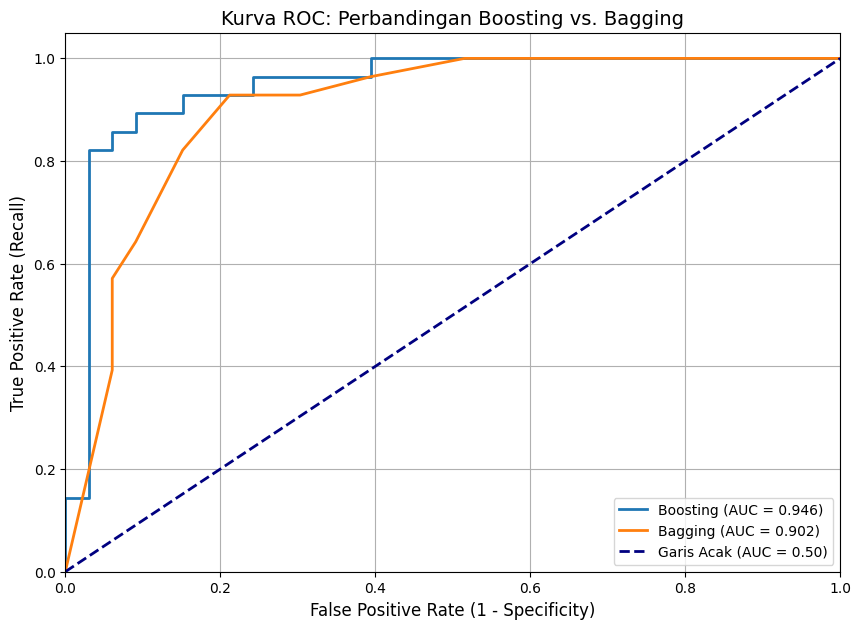

In [2]:
# 1. Mengimpor pustaka yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import StandardScaler

# --- Langkah 1: Memuat dan Membersihkan Data ---

# Memuat dataset dari file CSV
try:
    df = pd.read_csv('HeartDisease(1).csv', header=None)
except FileNotFoundError:
    print("Pastikan file 'HeartDisease(1).csv' berada di direktori yang sama dengan script ini.")
    exit()

# Menambahkan nama kolom secara manual
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
df.columns = column_names

# Mengganti karakter '?' dengan NaN
df.replace('?', np.nan, inplace=True)

# Mengonversi kolom yang seharusnya numerik menjadi tipe data numerik
for col in ['trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# *** PERBAIKAN DITAMBAHKAN DI SINI ***
# Mengonversi kolom 'target' menjadi numerik sebelum melakukan perbandingan
df['target'] = pd.to_numeric(df['target'], errors='coerce')
# Menghapus baris di mana 'target' menjadi NaN setelah konversi (jika ada)
df.dropna(subset=['target'], inplace=True)
# *** AKHIR DARI PERBAIKAN ***

# Mengisi nilai yang hilang (NaN) di kolom fitur
for col in ['trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'thal']:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)
for col in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']:
     if df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

# Memastikan kolom target menjadi biner: 0 (tidak ada penyakit) dan 1 (ada penyakit)
# Baris ini sekarang akan berjalan tanpa error
df['target'] = (df['target'] > 0).astype(int)

# --- Langkah 2: Menyiapkan Data untuk Model ---

# Memisahkan fitur (X) dan target (y)
X = df.drop('target', axis=1)
y = df['target']

# Menskalakan fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Membagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- Langkah 3: Membuat dan Melatih Model ---

# Model Boosting
boosting_model = GradientBoostingClassifier(random_state=42)
boosting_model.fit(X_train, y_train)
boosting_pred = boosting_model.predict(X_test)
boosting_pred_proba = boosting_model.predict_proba(X_test)[:, 1]

# Model Bagging
bagging_model = BaggingClassifier(random_state=42)
bagging_model.fit(X_train, y_train)
bagging_pred = bagging_model.predict(X_test)
bagging_pred_proba = bagging_model.predict_proba(X_test)[:, 1]


# --- Langkah 4: Mengevaluasi Performa Model ---

def evaluate_classification_model(y_true, y_pred, y_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    return {
        "Model": model_name, "Accuracy": accuracy, "Precision": precision,
        "Recall": recall, "F1-Score": f1, "AUC": auc
    }

boosting_metrics = evaluate_classification_model(y_test, boosting_pred, boosting_pred_proba, "Boosting")
bagging_metrics = evaluate_classification_model(y_test, bagging_pred, bagging_pred_proba, "Bagging")

comparison_df = pd.DataFrame([boosting_metrics, bagging_metrics])
print("--- Perbandingan Matriks Evaluasi ---")
print(comparison_df.to_string())


# --- Langkah 5: Membuat dan Menyimpan Plot Kurva ROC ---

fpr_boost, tpr_boost, _ = roc_curve(y_test, boosting_pred_proba)
fpr_bag, tpr_bag, _ = roc_curve(y_test, bagging_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr_boost, tpr_boost, lw=2, label=f'Boosting (AUC = {boosting_metrics["AUC"]:.3f})')
plt.plot(fpr_bag, tpr_bag, lw=2, label=f'Bagging (AUC = {bagging_metrics["AUC"]:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Garis Acak (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Kurva ROC: Perbandingan Boosting vs. Bagging', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve_comparison_fixed.png')

print("\nPlot Kurva ROC telah berhasil disimpan sebagai 'roc_curve_comparison_fixed.png'")